In [3]:
import matplotlib.pyplot as plt
#%matplotlib widget
from ipywidgets import *
import numpy as np
import sys

In [4]:
import taurex.log
taurex.log.disableLogging()

In [7]:
from taurex.cache import OpacityCache,CIACache
OpacityCache().clear_cache()
OpacityCache().set_opacity_path("../atmosphere/xsecs")
CIACache().set_cia_path("../atmosphere/cia/hitran")


In [8]:
from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=1200.0)

In [9]:
from taurex.planet import Planet
planet = Planet(planet_radius=1.7420,planet_mass=1.170)  #in jupiter masses

#parameters retrieved from https://ui.adsabs.harvard.edu/abs/2024AJ....168..231S/abstract

In [10]:
from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=6628,radius=1.461)

Numba not installed, using numpy instead


In [11]:
from taurex.chemistry import TaurexChemistry
from taurex.chemistry import ConstantGas
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)
# H2O, CH4, CO2 and CO randomised within [10^{-8},10^{-2}].
rng = np.random.default_rng(seed=100)
chemistry.addGas(ConstantGas('H20',mix_ratio=rng.uniform(1e-8,1e-2)))
chemistry.addGas(ConstantGas('CH4',mix_ratio=rng.uniform(1e-8,1e-2)))
chemistry.addGas(ConstantGas('CO2',mix_ratio=rng.uniform(1e-8,1e-2)))
chemistry.addGas(ConstantGas('CO',mix_ratio=rng.uniform(1e-8,1e-2)))

In [12]:
from taurex.model import TransmissionModel
from taurex.contributions import AbsorptionContribution
from taurex.contributions import CIAContribution
from taurex.contributions import RayleighContribution

tm = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                       atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)
tm.add_contribution(AbsorptionContribution())
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
tm.add_contribution(RayleighContribution())
tm.build()
res = tm.model()
res

(array([  199.99326855,   200.00660143,   200.01993521, ...,
        33328.88933329, 33331.11125925, 33333.33333333], shape=(76744,)),
 array([0.0160977 , 0.01613024, 0.0159089 , ..., 0.01583692, 0.01583695,
        0.01583698], shape=(76744,)),
 array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.08710276e-010, 1.08710276e-010, 1.08710276e-010],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.10576658e-264, 9.28936531e-265, 7.80343340e-265],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         8.01701937e-167, 7.18002676e-167, 6.43020330e-167],
        ...,
        [9.33559432e-001, 8.12833966e-001, 9.94108024e-001, ...,
         9.96181405e-001, 9.96180296e-001, 9.96179186e-001],
        [9.71893807e-001, 8.59807327e-001, 9.96763477e-001, ...,
         9.97876359e-001, 9.97875741e-001, 9.97875123e-001],
        [9.89408347e-001, 9.28885909e-001, 9.98575574e-001, ...,
         9.99081512e-001, 9.99081245e-001, 9.9

In [ ]:
#from astropy.table import Table
#t = Table.read("WASP_121_b_3.11900_5699_2.tbl", format="ipac")
#t["CENTRALWAVELNG", "PL_TRANDEP", "PL_TRANDEPERR1", "PL_TRANDEPERR2"].write(
#    "spectrum.dat",
#    format="ascii.no_header"

/root/anaconda3/envs/comp_astro_25/lib/python3.10/site-packages/taurex/util/util.py:379: RuntimeWarning: invalid value encountered in divide
  np.histogram(original_bin, filter_lhs, weights=original_data)[0]


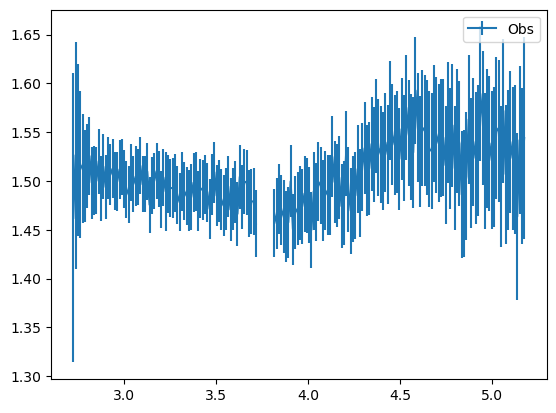

Text(0.5, 1.0, 'WASP-121b Spectrum')

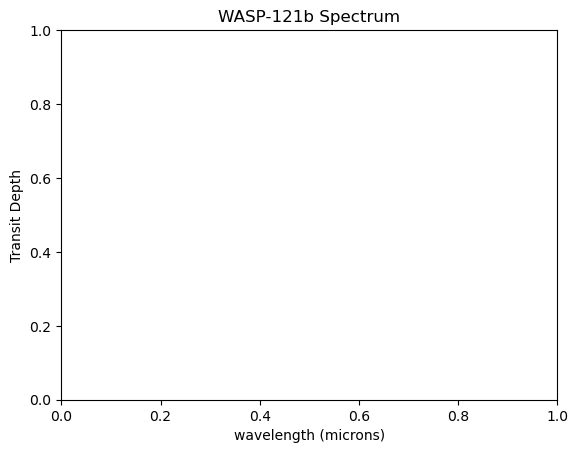

In [13]:
from taurex.data.spectrum.observed import ObservedSpectrum
from taurex.binning import SimpleBinner

obs = ObservedSpectrum('./WASP121bspectrum.dat')
#Make a logarithmic grid or a linear in the wavelength
wngrid = np.sort(10000/np.linspace(2.7,5.2,200))
bn = SimpleBinner(wngrid=wngrid)

bin_obs= bn.bindown(obs.wavenumberGrid, obs.spectrum)
errorbars = bn.bindown(obs.wavenumberGrid, obs.errorBar)
obin = obs.create_binner()

plt.figure()
plt.errorbar(1e4/wngrid, bin_obs[1], yerr=errorbars[1], label='Obs')
#plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
plt.legend()
plt.show()
plt.xlabel("wavelength (microns)")
plt.ylabel("Transit Depth")
plt.title("WASP-121b Spectrum")